#Прогнозирование необходимости технического обслуживания оборудования в машиностроительной отрасли

Для повышения эффективности производства рекомендуется проводить ремонт оборудования ни при появлении фиксированной неисправности, а заранее, чтобы сократить время простоя оборудования. Использование искусственного интеллекта для прогнозного технического обслуживания позволяет предприятиям распознать любой риск возникновения ошибки или неисправности до того, как они произойдут.

Поскольку реальные наборы данных по прогнозированию технического обслуживания обычно трудно получить и особенно трудно опубликовать, данные, предоставленные репозиторием UCI, представляют собой синтетический набор данных, который в максимальной степени отражает реальное прогнозирование технического обслуживания, встречающееся в промышленности.

Описание данных:
- Product ID -  уникальный идентификатор для каждой точки данных
- Type - состоит из букв L, M или H для низкого (60 % всех продуктов), среднего (30 %) и высокого (10 %) вариантов качества продукта и серийного номера для конкретного варианта.
- Air temperature - генерируется с использованием процесса случайного блуждания, позже нормируется до стандартного отклонения 2 К около 300 К.
- Process temperature - генерируется с использованием процесса случайного блуждания, нормированного на стандартное отклонение 1 К, добавленное к температуре воздуха плюс 10 К.
- Rotational speed - рассчитано на основе мощности 2860 Вт с наложением нормально распределенного шума.
- Torque - значения крутящего момента обычно распределяются в районе 40 Нм с Ïƒ = 10 Нм и без отрицательных значений.
- Tool wear - варианты качества H/M/L добавляют 5/3/2 минуты износа используемого инструмента в процессе. и метка «отказ машины», которая указывает, верен ли сбой машины в этой конкретной точке данных для любого из следующих режимов отказа.
- Failure Type - тип неисправности

In [ ]:
!pip install catboost

In [2]:
# импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import sklearn
import joblib

from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.metrics import r2_score, f1_score, roc_auc_score, accuracy_score, precision_score, confusion_matrix, recall_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore")

In [3]:
# загрузка файла с диска kaggle.json
!gdown 1UcxF4fICXEWWMnGmDAGi4xJy2gr2FTC2

#https://drive.google.com/file/d/1UcxF4fICXEWWMnGmDAGi4xJy2gr2FTC2/view?usp=drive_link

Traceback (most recent call last):
  File "/usr/local/bin/gdown", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.10/dist-packages/gdown/cli.py", line 151, in main
    filename = download(
  File "/usr/local/lib/python3.10/dist-packages/gdown/download.py", line 203, in download
    filename_from_url = m.groups()[0]
AttributeError: 'NoneType' object has no attribute 'groups'


In [4]:
# создаем .kaggle папку на диске
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [5]:
# загрузка датасета
!kaggle datasets download -d shivamb/machine-predictive-maintenance-classification

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.10/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 403, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [6]:
# распаковка архива датасета
!unzip -q /content/machine-predictive-maintenance-classification.zip

unzip:  cannot find or open /content/machine-predictive-maintenance-classification.zip, /content/machine-predictive-maintenance-classification.zip.zip or /content/machine-predictive-maintenance-classification.zip.ZIP.


In [7]:
# открываем файл
data = pd.read_csv('/content/predictive_maintenance.csv')

In [8]:
# выводим первые 5 строк
data.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


# Исследовательский анализ данных

In [9]:
# изменим заголовки столбцов
data.rename(columns = {'Air temperature [K]': 'Air_temperature',
                       'Process temperature [K]': 'Process_temperature',
                       'Rotational speed [rpm]': 'Rotational_speed',
                       'Torque [Nm]': 'Torque',
                       'Tool wear [min]': 'Tool_wear',
                       'Failure Type' : 'Failure_Type'}, inplace = True)

In [10]:
# вывод общей информации
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   UDI                  10000 non-null  int64  
 1   Product ID           10000 non-null  object 
 2   Type                 10000 non-null  object 
 3   Air_temperature      10000 non-null  float64
 4   Process_temperature  10000 non-null  float64
 5   Rotational_speed     10000 non-null  int64  
 6   Torque               10000 non-null  float64
 7   Tool_wear            10000 non-null  int64  
 8   Target               10000 non-null  int64  
 9   Failure_Type         10000 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB


In [11]:
# проверка дубликатов
data.duplicated().sum()

0

Убедились что пропуски и дубликаты отсутствуют, тип данных соответсвует значениям

In [12]:
# смотрим описательную статистику
data.describe().T

,count,mean,std,min,25%,50%,75%,max
UDI,10000.0,5000.50000,2886.895680,1.0,2500.75,5000.5,7500.25,10000.0
Air_temperature,10000.0,300.00493,2.000259,295.3,298.30,300.1,301.50,304.5
Process_temperature,10000.0,310.00556,1.483734,305.7,308.80,310.1,311.10,313.8
Rotational_speed,10000.0,1538.77610,179.284096,1168.0,1423.00,1503.0,1612.00,2886.0
Torque,10000.0,39.98691,9.968934,3.8,33.20,40.1,46.80,76.6
Tool_wear,10000.0,107.95100,63.654147,0.0,53.00,108.0,162.00,253.0
Target,10000.0,0.03390,0.180981,0.0,0.00,0.0,0.00,1.0


In [13]:
# смотрим описательную статистику для категориальных данных
data.describe(include=['object']).T

,count,unique,top,freq
Product ID,10000,10000,M14860,1
Type,10000,3,L,6000
Failure_Type,10000,6,No Failure,9652


In [14]:
#смотрим частоту упоминания вариантов качества
data['Type'].value_counts()

L    6000
M    2997
H    1003
Name: Type, dtype: int64

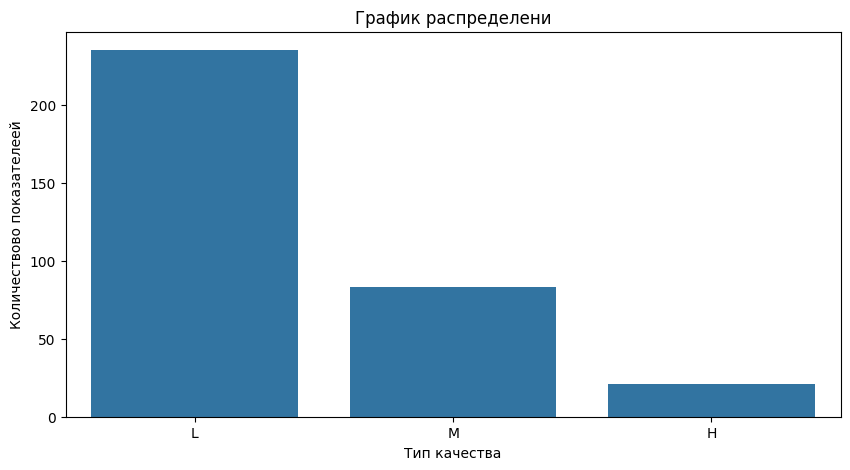

In [15]:
# визуализируем данные
plt.figure(figsize=(10,5))
sns.countplot(data=data[data['Target']==1],x="Type")
plt.title('График распределени')
plt.xlabel("Тип качества")
plt.ylabel("Количествово показателеей")
plt.show()

In [16]:
# смотрим частоту предсказания неисправности
data['Target'].value_counts()

0    9661
1     339
Name: Target, dtype: int64

Cледует обратить внимание на дисбаланс классов

In [17]:
# смотрим типы неисправности и частоту их упоминания
data['Failure_Type'].value_counts()

No Failure                  9652
Heat Dissipation Failure     112
Power Failure                 95
Overstrain Failure            78
Tool Wear Failure             45
Random Failures               18
Name: Failure_Type, dtype: int64

Отсутствие отказов  9652

Отказ теплоотвода  112

Отказ питания 95

Отказ при перегрузках 78

Отказ при износе инструмента 45

Случайные отказы 18

In [18]:
# проверка неисправностей
data[data['Target'] == 1]['Failure_Type'].value_counts()

Heat Dissipation Failure    112
Power Failure                95
Overstrain Failure           78
Tool Wear Failure            45
No Failure                    9
Name: Failure_Type, dtype: int64

Можем заметить что 9 неисправностей отмечены как поломка в столбце Target и как отсутствие отказа в столбце Failure_Type, предлагаю удалить данные значения

In [19]:
#удаляем противоречивые данные
index_drop_failure = data[(data['Target'] == 1 ) & (data['Failure_Type'] == 'No Failure')].index
data.drop(index_drop_failure, axis=0, inplace=True)

In [20]:
# проверка неисправностей
data[data['Target'] == 0]['Failure_Type'].value_counts()

No Failure         9643
Random Failures      18
Name: Failure_Type, dtype: int64

В данном случае мы можем заметить что 18 неисправностей отмечены как случайный отказ в столбце Failure_Type  и как отсутствие отказа в столбце Target, предлагаю так же удалить данные значения

In [21]:
#удаляем противоречивые данные
index_drop_failure = data[(data['Target'] == 0 ) & (data['Failure_Type'] == 'Random Failures')].index
data.drop(index_drop_failure, axis=0, inplace=True)

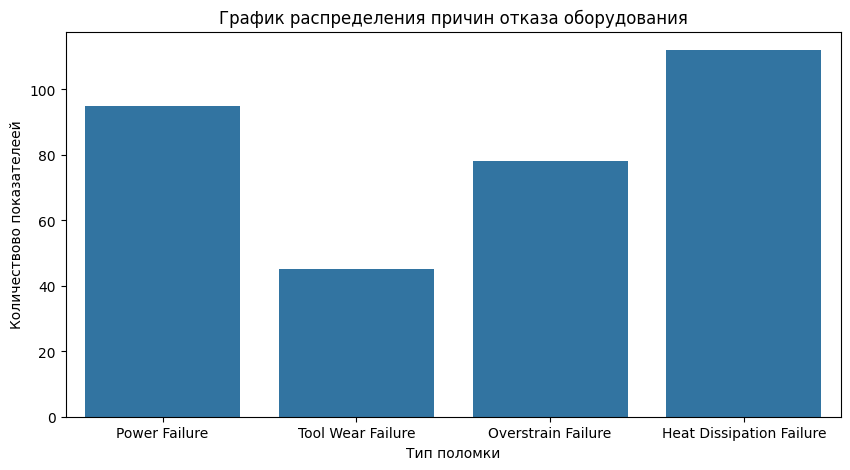

In [22]:
# визуализируем данные
plt.figure(figsize=(10,5))
sns.countplot(data=data[data['Target']==1],x="Failure_Type")
plt.title('График распределения причин отказа оборудования')
plt.xlabel("Тип поломки")
plt.ylabel("Количествово показателеей")
plt.show()

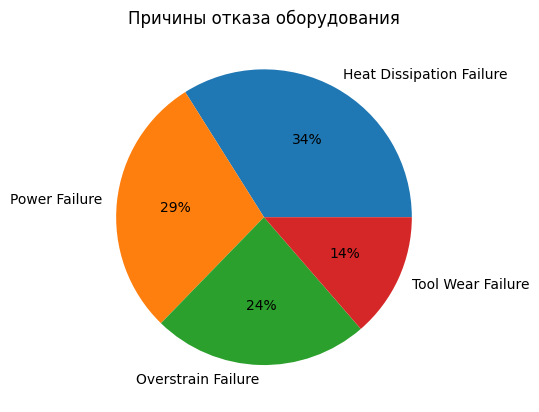

In [23]:
idx_fail = data.loc[data['Failure_Type'] != 'No Failure'].index
data_fail = data.loc[idx_fail]
data_fail_percentage = 100*data_fail['Failure_Type'].value_counts()/data_fail['Failure_Type'].shape[0]
plt.title('Причины отказа оборудования')
plt.pie(x=data_fail_percentage.array, labels=data_fail_percentage.index.array,
        colors=sns.color_palette('tab10')[0:4], autopct='%.0f%%')
plt.show()

In [24]:
data.columns

Index(['UDI', 'Product ID', 'Type', 'Air_temperature', 'Process_temperature',
       'Rotational_speed', 'Torque', 'Tool_wear', 'Target', 'Failure_Type'],
      dtype='object')

In [25]:
# выделяем количественные признаки для дальнейшей визуализации
quantity = ['Air_temperature', 'Process_temperature', 'Rotational_speed',
       'Torque', 'Tool_wear']

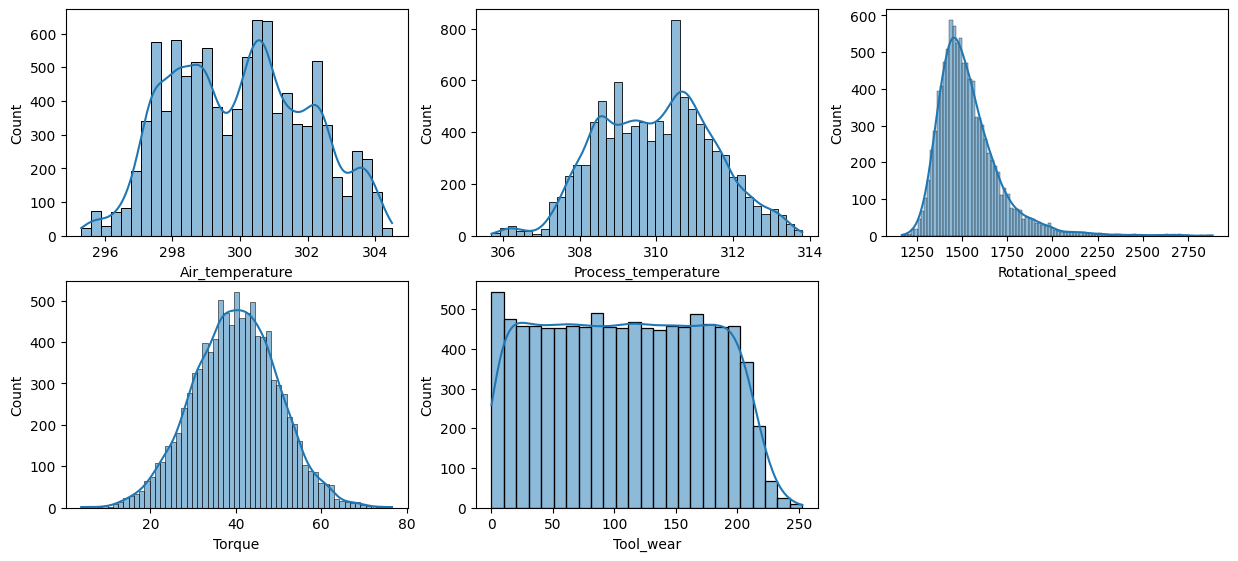

In [26]:
# визуализируем данные
plt.figure(figsize=(15,10))
for i,col in enumerate(data[quantity],1):
    plt.subplot(3,3,i)
    sns.histplot(data[col],kde=True)

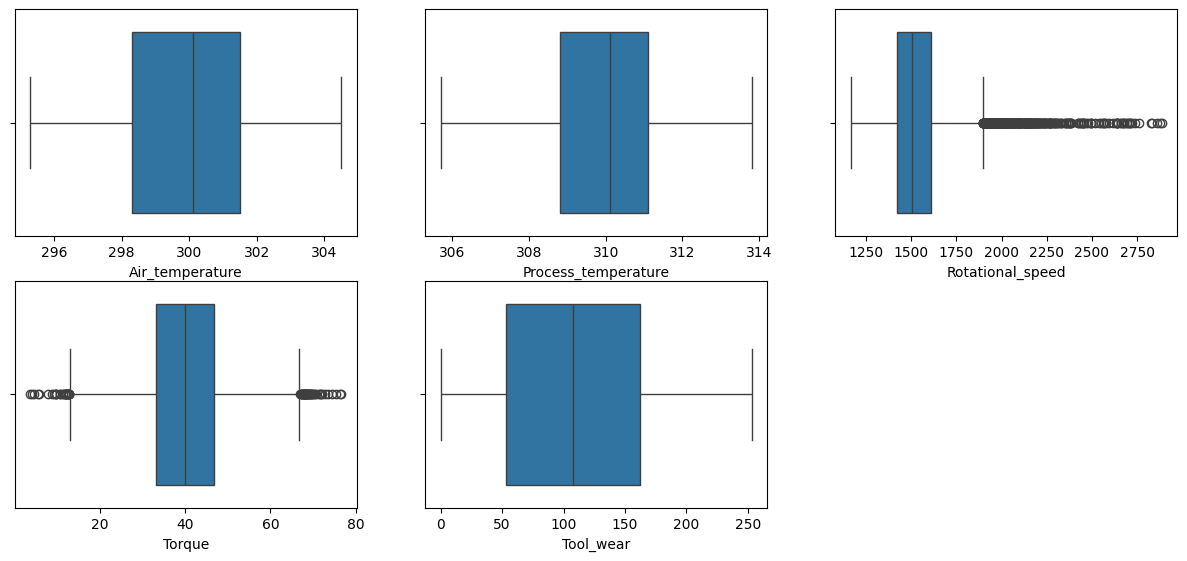

In [27]:
# визуализируем данные
plt.figure(figsize=(15,10))
for i,col in enumerate(data[quantity],1):
    plt.subplot(3,3,i)
    sns.boxplot(data=data, x=col)

Видим что нормальное распределение только у признака 'Torque', выбросы имеются в столбцах  'Torque' и 'Rotational_speed', оставим пока их без изменений

In [28]:
# удалим неинформативные столбцы
data = data.drop(["UDI",'Product ID'],axis=1)

In [29]:
# проверка результата
data.head()

,Type,Air_temperature,Process_temperature,Rotational_speed,Torque,Tool_wear,Target,Failure_Type
0,M,298.1,308.6,1551,42.8,0,0,No Failure
1,L,298.2,308.7,1408,46.3,3,0,No Failure
2,L,298.1,308.5,1498,49.4,5,0,No Failure
3,L,298.2,308.6,1433,39.5,7,0,No Failure
4,L,298.2,308.7,1408,40.0,9,0,No Failure


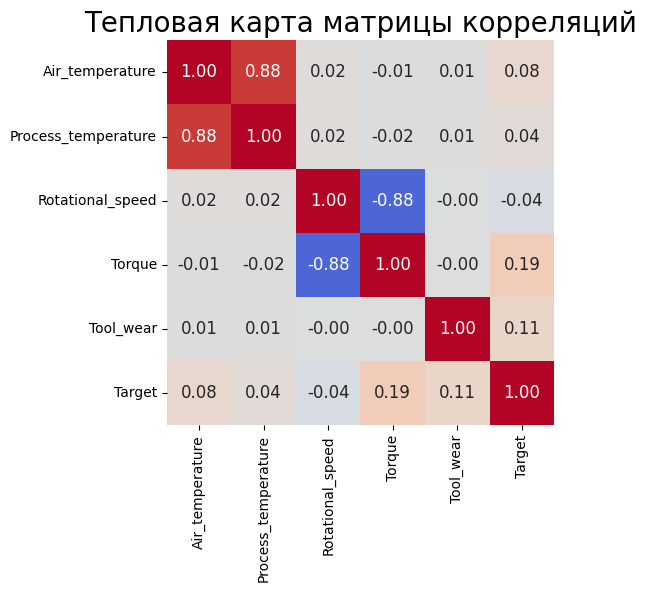

In [30]:
# строим корреляционнцю матрицу
plt.figure(figsize=(5, 5))

a = sns.heatmap(data.corr(),
            annot=True,
            cmap= 'coolwarm',
            cbar=False,
            fmt='.2f',
            annot_kws={"fontsize": 12},
            vmin=-1,
            vmax=1)
a.set_title('Тепловая карта матрицы корреляций', fontsize=20)
plt.show()

Факторов сильно коррелирующих с целевым признаком нет.

In [31]:
# смотрим типы неисправности и частоту их упоминания
data.pivot_table( index= ['Target', 'Failure_Type'], values='Type', aggfunc='count')

Type
Target Failure_Type                  
0      No Failure                9643
1      Heat Dissipation Failure   112
       Overstrain Failure          78
       Power Failure               95
       Tool Wear Failure           45

# Подготовка признаков и обучение модели

В качестве целевой переменной могут выступать как 'Target' так и 'Failure Type'

Кроме того, для дальнейшего обучения моделей необходимо преобразовать категориальные признаки в численные и сбалансировать классы

## Целевой признак 'Target', задача бинарной классификации

In [32]:
 # Выделим признаки и целевой показатель
features = data.drop(columns=['Failure_Type', 'Target'], axis = 1)
target = data['Target']

In [33]:
# Делим данные на обучающую и тестовую выборки
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25,
                                                                                  random_state=123)
features_valid, features_test, target_valid, target_test = train_test_split(features_test, target_test, test_size=0.5,
                                                                                  random_state=123)
print('Размер обучающей выборки - ', features_train.shape, 'что составляет', round(features_train.shape[0] / data.shape[0]*100,2), '% от исходного')
print('Размер тестовой выборки - ',  features_test.shape, 'что составляет', round(features_test.shape[0] / data.shape[0]*100,2), '%  от исходного')
print('Размер валидационной выборки - ',  features_valid.shape, 'что составляет', round(features_valid.shape[0] / data.shape[0]*100,2), '%  от исходного')

Размер обучающей выборки -  (7479, 6) что составляет 74.99 % от исходного
Размер тестовой выборки -  (1247, 6) что составляет 12.5 %  от исходного
Размер валидационной выборки -  (1247, 6) что составляет 12.5 %  от исходного


In [34]:
#категориальные признаки для OHE
ohe_features= features_train.select_dtypes(include='object').columns.to_list()
print(ohe_features)

['Type']


In [35]:
#численные признаки
num_features = features_train.select_dtypes(exclude='object').columns.to_list()
num_features

['Air_temperature',
 'Process_temperature',
 'Rotational_speed',
 'Torque',
 'Tool_wear']

In [36]:
# drop='first' удаляет первый признак из закодированных:
# таким образом обходим dummy-ловушку
# задаём handle_unknown='ignore':
# игнорируется ранее невстречающиеся значения признака (при transform)
encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)

# обучаем энкодер на заданных категориальных признаках тренировочной выборки
encoder_ohe.fit(features_train[ohe_features])

# добавляем закодированные признаки в features_train_ohe
# encoder_ohe.get_feature_names_out() позволяет получить названия колонок
features_train[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(features_train[ohe_features])

# удаляем незакодированные категориальные признаки (изначальные колонки)
features_train = features_train.drop(ohe_features, axis=1)

# создаём скелер
scaler = StandardScaler()

# обучаем его на численных признаках тренировочной выборки, трансформируем её же
features_train[num_features] = scaler.fit_transform(features_train[num_features])

# смотрим на результат
features_train.head()

,Air_temperature,Process_temperature,Rotational_speed,Torque,Tool_wear,Type_L,Type_M
466,-1.404701,-1.018086,0.063565,0.148055,0.271900,1.0,0.0
7391,-0.151389,0.404597,0.753355,-0.869596,0.334521,1.0,0.0
1300,-0.652714,-0.137378,-1.194612,1.694485,0.506730,1.0,0.0
8984,-1.454834,-1.492313,-0.731073,2.033702,0.397142,1.0,0.0
3113,-0.051125,-0.611605,-1.067691,1.674531,-1.528467,0.0,1.0


In [37]:
# энкодером, который обучен на ТРЕНИРОВОЧНОЙ ВЫБОРКЕ, кодируем тестовую и валидационную
features_test[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(features_test[ohe_features])

features_test = features_test.drop(ohe_features, axis=1)

features_valid[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(features_valid[ohe_features])

features_valid = features_valid.drop(ohe_features, axis=1)
# скелером, который обучен на ТРЕНИРОВОЧНОЙ ВЫБОРКЕ, масштабируем тестовую  и валидационную
features_test[num_features] = scaler.transform(
    features_test[num_features]
)

features_valid[num_features] = scaler.transform(
    features_valid[num_features]
)
# смотрим на результат
features_test.head()

,Air_temperature,Process_temperature,Rotational_speed,Torque,Tool_wear,Type_L,Type_M
3782,1.101922,0.540090,1.592140,-1.617868,-1.544122,1.0,0.0
8229,-0.452184,0.336850,1.106528,-1.258698,-0.557834,1.0,0.0
2351,-0.402052,-1.085833,-0.802811,0.836466,-1.137083,1.0,0.0
2418,-0.552449,-1.153579,0.670580,-0.560310,-1.544122,1.0,0.0
2938,0.349935,-0.340618,-0.328236,-0.550333,1.399085,1.0,0.0


Для балансировки классов используем SMOTE

In [38]:
# увеличение поломок в выборке
oversample = SMOTE(random_state=123)
features_train_up, target_train_up = oversample.fit_resample(features_train, target_train)
features_test_up, target_test_up = oversample.fit_resample(features_test, target_test)
features_valid_up, target_valid_up = oversample.fit_resample(features_valid, target_valid)

In [39]:
# напишем функцию для оценки качества модели
def fit_models(model, features_train, features_test, target_train, target_test):

    model.fit(features_train, target_train)
    pred = model.predict(features_test)

    accuracy = accuracy_score(target_test,pred)
    precision = precision_score(target_test,pred)
    recall = recall_score(target_test,pred)
    f1 = f1_score(target_test,pred)
    cm = confusion_matrix(target_test,pred)
    print(f"Значение accuracy = {round(accuracy,4)}, precision = {round(precision,4)}, recall = {round(recall,4)}, f1 = {round(f1,4)} ")
    print('')
    plt.figure(figsize=(3,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='flare', annot_kws={"size": 10, "weight": "bold"});
    return accuracy, precision, recall, f1, cm

####  LogisticRegression

In [40]:
# обучим модель логистической регрессии на сбалансированной выборке
model_lr = LogisticRegression(random_state=123)

Значение accuracy = 0.7985, precision = 0.8321, recall = 0.7479, f1 = 0.7878 



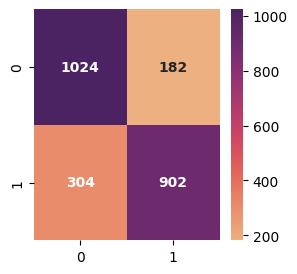

In [41]:
# получим метрики качества
accuracy_lr, precision_lr, recall_lr, f1_lr, cm_lr = fit_models(model_lr, features_train_up, features_test_up, target_train_up, target_test_up)

####  RandomForest

In [42]:
# обучим модель случайного леса на сбалансированной выборке
model_rf = RandomForestClassifier(random_state=123) # создадим модель

Значение accuracy = 0.8711, precision = 0.9725, recall = 0.7637, f1 = 0.8556 



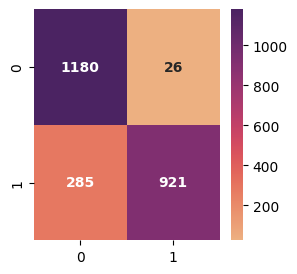

In [43]:
# получим метрики качества
accuracy_rf, precision_rf, recall_rf, f1_rf, cm_rf = fit_models(model_rf, features_train_up, features_test_up, target_train_up, target_test_up)

####  CatBoostClassifier

In [44]:
# обучим модель градиентного спуска на сбалансированной выборке
model_c = CatBoostClassifier(verbose=False, iterations=200)

Значение accuracy = 0.9038, precision = 0.9728, recall = 0.8308, f1 = 0.8962 



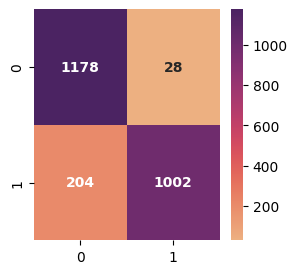

In [45]:
# получим метрики качества
accuracy_с, precision_с, recall_с, f1_с, cm_с = fit_models(model_c, features_train_up, features_test_up, target_train_up, target_test_up)

####  XGBClassifier

In [46]:
# обучим модель  на сбалансированной выборке
model_x = XGBClassifier(verbose=False, iterations=200)

Значение accuracy = 0.8968, precision = 0.979, recall = 0.8109, f1 = 0.8871 



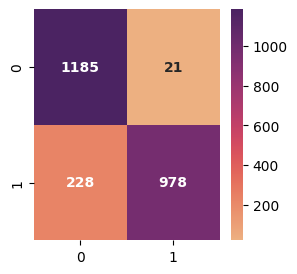

In [47]:
# получим метрики качества
accuracy_x, precision_x, recall_x, f1_x, cm_x = fit_models(model_x, features_train_up, features_test_up, target_train_up, target_test_up)

Чтобы было лучшее понимание метрик качества, дадим им небольшое объяснение:
- Accuracy(правильность) - Показывает отношение числа правильных ответов к размеру тестовой выборки
- Precission (Точность) -  определяет, как много отрицательных ответов нашла модель, пока искала положительные.
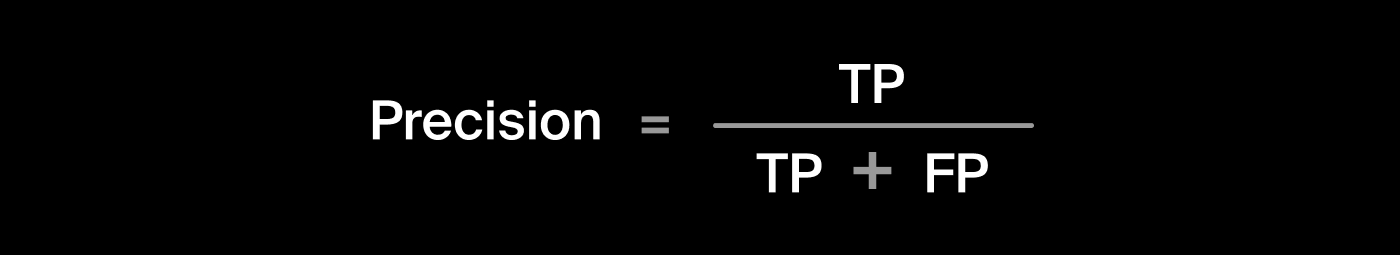
- Recall(Полнота)- выявляет, какую долю положительных среди всех ответов выделила модель.
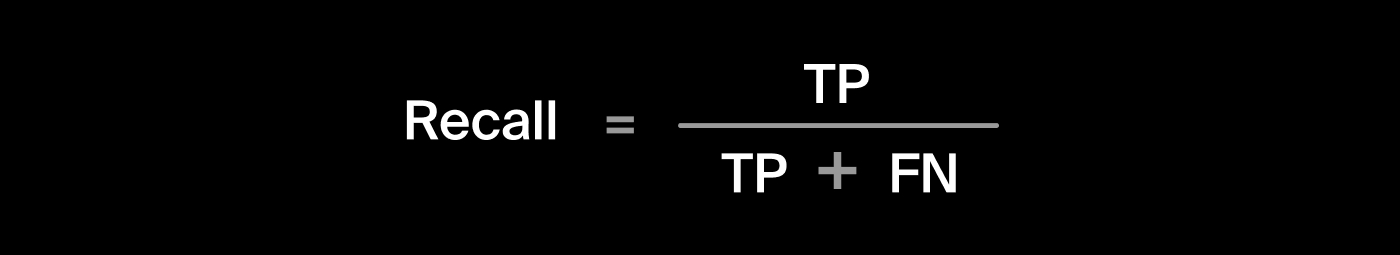
- F1-мера - По отдельности полнота и точность не слишком информативны. Нужно одновременно повышать показатели обеих. Контролировать их параллельно помогают агрегирующие метрики, одна из которых — F1-мера (англ. F1-score). Это среднее гармоническое полноты и точности.
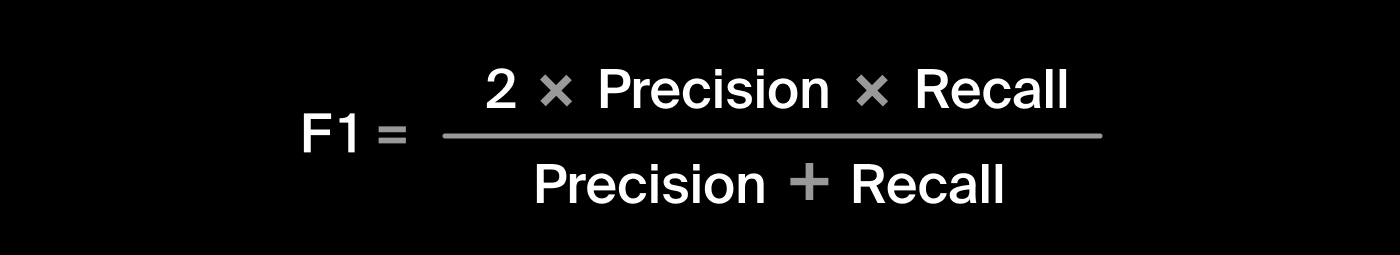
- Матрица ошибок позволяет наглядно представить результаты вычислений метрик точности и полноты
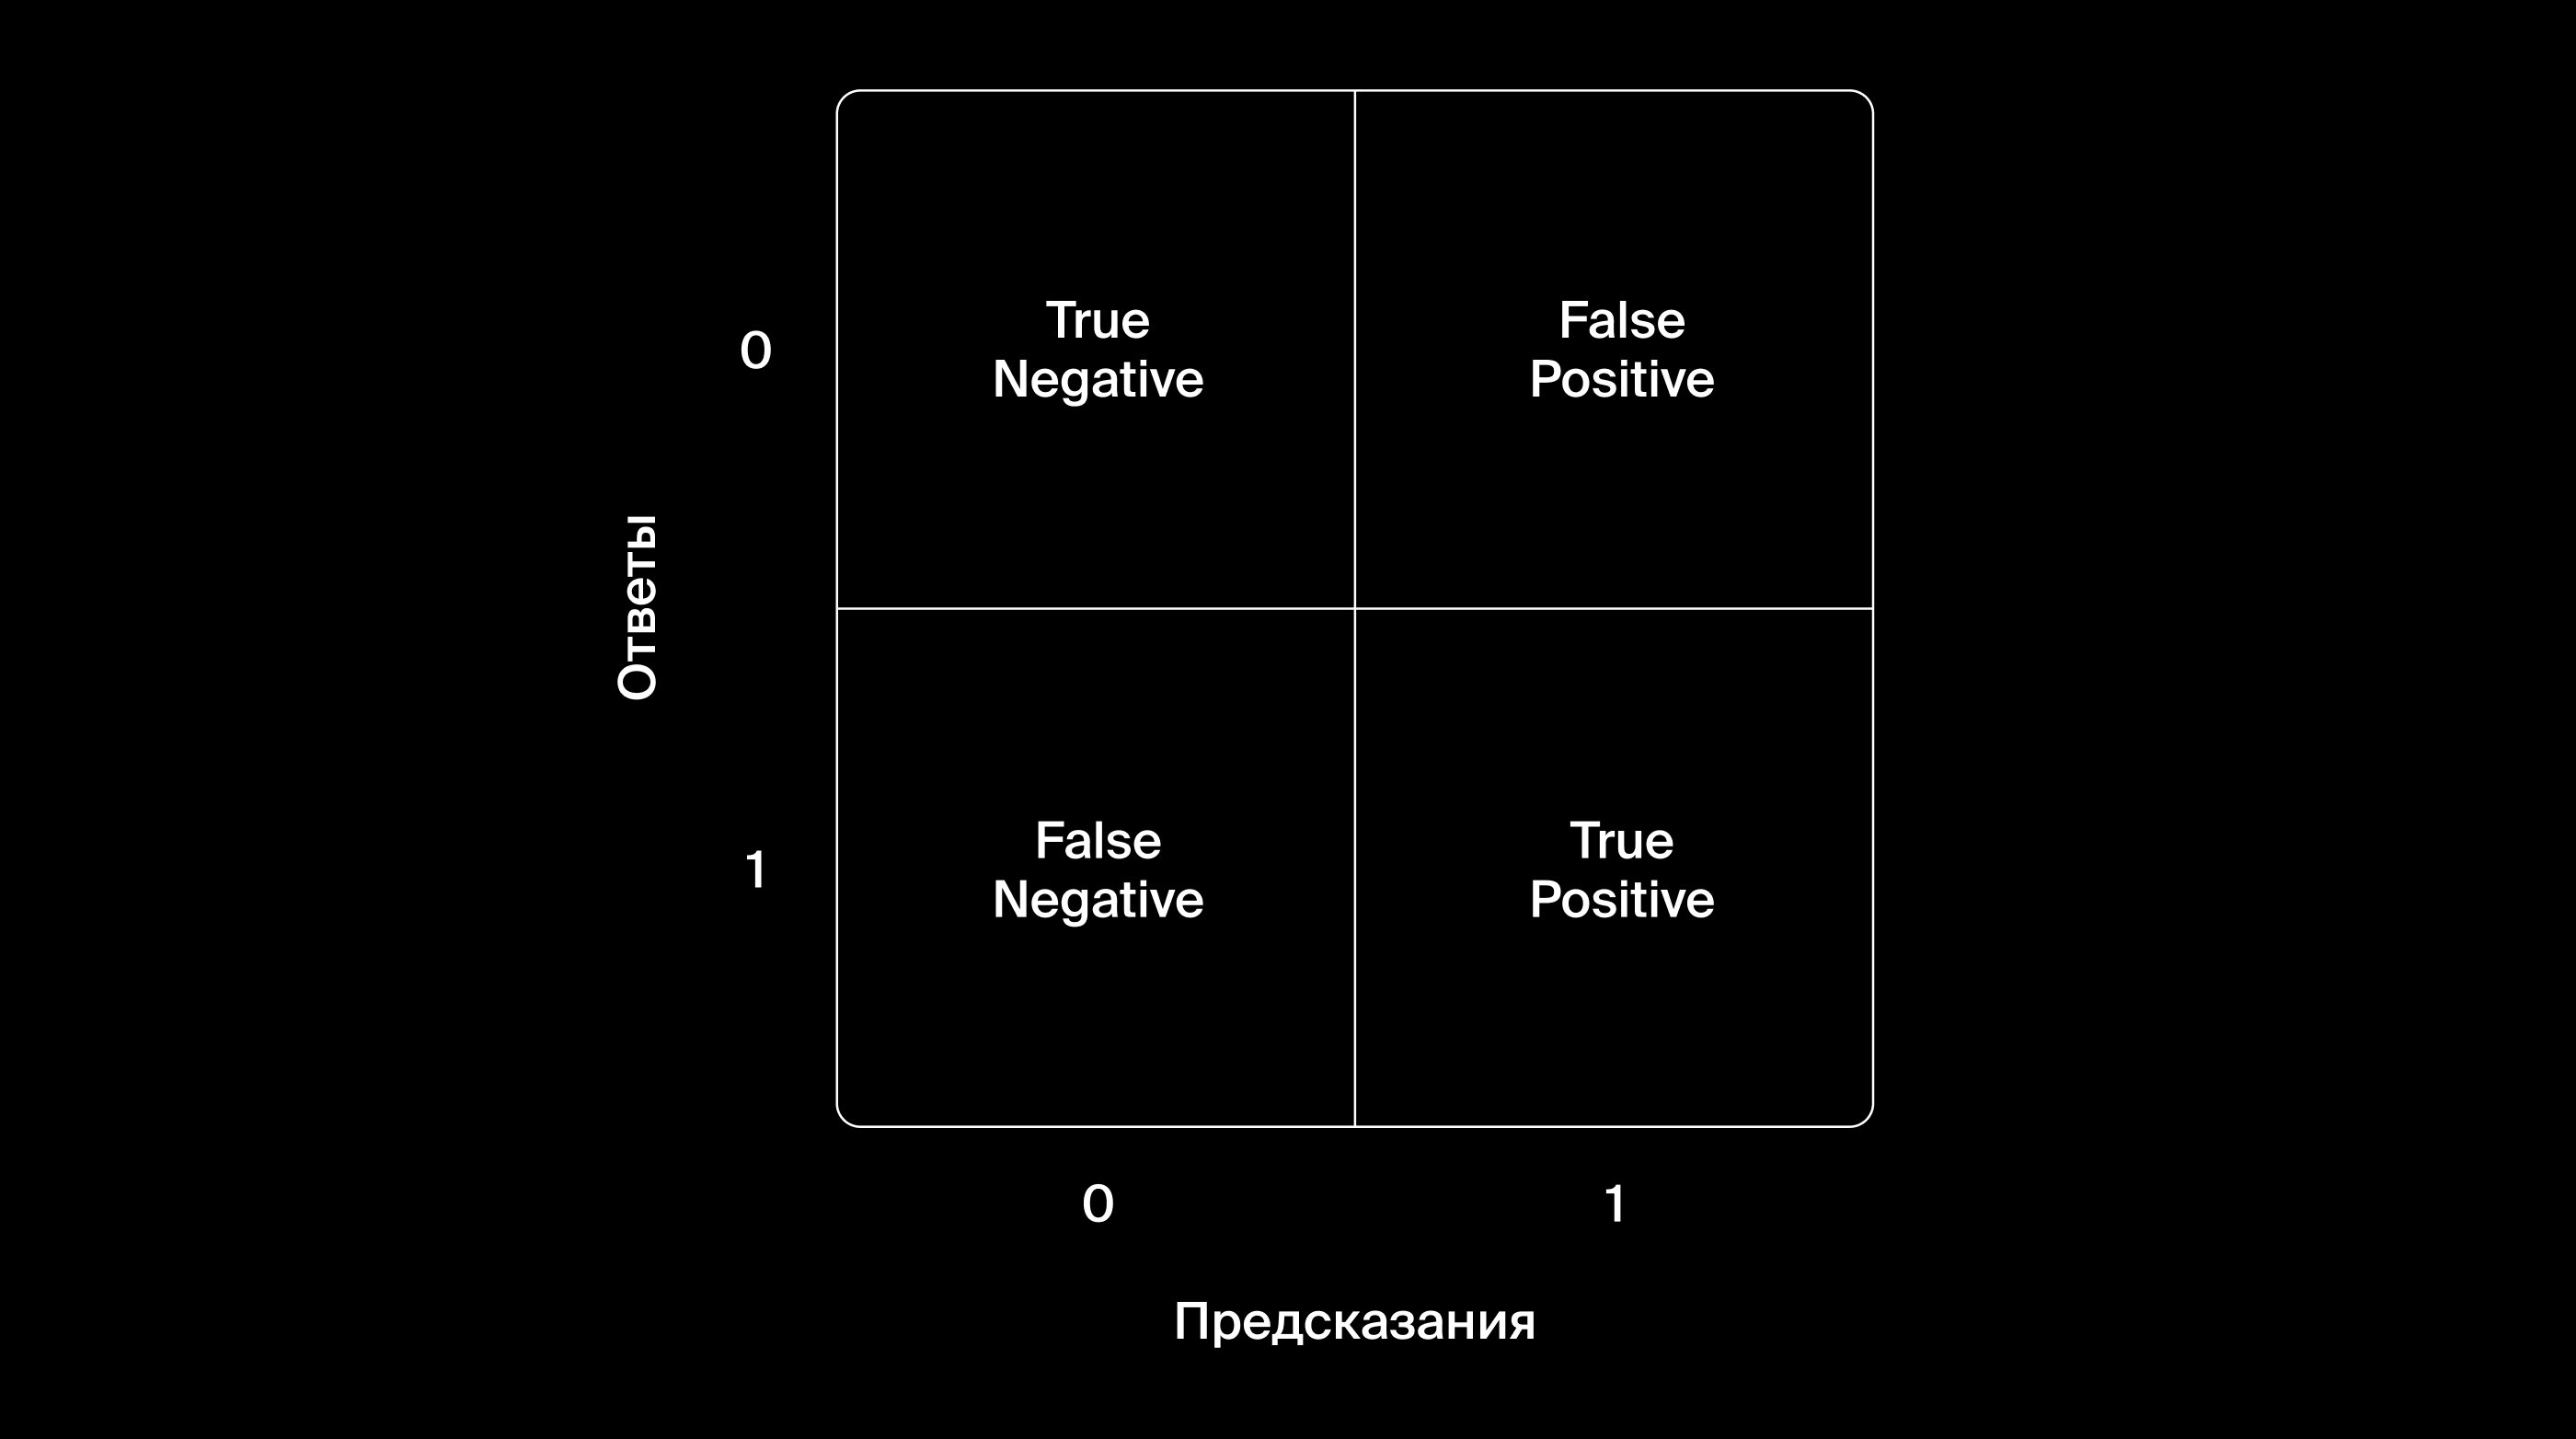

In [48]:
# выбор лучшей модели
column=['Accuracy', 'Precision', 'Recall', 'F1']

summary = pd.DataFrame(index=column, columns=['LogisticRegression','RandomForest','CatBoostClassifier', 'XGBClassifier'])
summary['LogisticRegression'] = accuracy_lr, precision_lr, recall_lr, f1_lr
summary['RandomForest'] = accuracy_rf, precision_rf, recall_rf, f1_rf
summary['CatBoostClassifier'] = accuracy_с, precision_с, recall_с, f1_с
summary['XGBClassifier'] = accuracy_x, precision_x, recall_x, f1_x
summary.T

,Accuracy,Precision,Recall,F1
LogisticRegression,0.798507,0.832103,0.747927,0.787773
RandomForest,0.871061,0.972545,0.763682,0.855550
CatBoostClassifier,0.903814,0.972816,0.830846,0.896243
XGBClassifier,0.896766,0.978979,0.810945,0.887075


Итак, наилучшая модель бинарной классификации основана на алгоритме - CatBoostClassifier. Немного позже посмотрим как она покажет себя на тестовой выборке

In [49]:
# сохраним лучшую модель
filename = 'CatBoost_best_model.pkl'
joblib.dump(model_c, filename)

['CatBoost_best_model.pkl']

## Целевой признак 'Failure Type', задача многоклассовой классификации

In [50]:
# выделяем категориальные признаки
columns_failure_type = data['Failure_Type'].unique().tolist()
ord_enc = OrdinalEncoder(categories=[['L', 'M', 'H'], columns_failure_type])

# обучаем энкодер на заданных категориальных признаках
new_dat = ord_enc.fit_transform(data[['Type', 'Failure_Type']])
new_dat
data.drop(['Type', 'Failure_Type'], axis=1, inplace=True)

new_data = pd.DataFrame(new_dat,
                      index=data.index,
                      columns=['Type', 'Failure_Type'])

data = pd.concat([data, new_data], axis=1)

In [51]:
 # Выделим признаки и целевой показатель
features = data.drop(columns=['Failure_Type', 'Target'], axis = 1)
target = data['Failure_Type']

In [52]:
# Делим данные на обучающую и тестовую выборки
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25,
                                                                                  random_state=123)
features_valid, features_test, target_valid, target_test = train_test_split(features_test, target_test, test_size=0.5,
                                                                                  random_state=123)
print('Размер обучающей выборки - ', features_train.shape, 'что составляет', round(features_train.shape[0] / data.shape[0]*100,2), '% от исходного')
print('Размер тестовой выборки - ',  features_test.shape, 'что составляет', round(features_test.shape[0] / data.shape[0]*100,2), '%  от исходного')
print('Размер валидационной выборки - ',  features_valid.shape, 'что составляет', round(features_valid.shape[0] / data.shape[0]*100,2), '%  от исходного')

Размер обучающей выборки -  (7479, 6) что составляет 74.99 % от исходного
Размер тестовой выборки -  (1247, 6) что составляет 12.5 %  от исходного
Размер валидационной выборки -  (1247, 6) что составляет 12.5 %  от исходного


In [53]:
# создаём скелер
scaler = StandardScaler()

# обучаем его на численных признаках тренировочной выборки, трансформируем её же
features_train[num_features] = scaler.fit_transform(features_train[num_features])

# смотрим на результат
features_train.head()

,Air_temperature,Process_temperature,Rotational_speed,Torque,Tool_wear,Type
466,-1.404701,-1.018086,0.063565,0.148055,0.271900,0.0
7391,-0.151389,0.404597,0.753355,-0.869596,0.334521,0.0
1300,-0.652714,-0.137378,-1.194612,1.694485,0.506730,0.0
8984,-1.454834,-1.492313,-0.731073,2.033702,0.397142,0.0
3113,-0.051125,-0.611605,-1.067691,1.674531,-1.528467,1.0


In [54]:
# скелером, который обучен на ТРЕНИРОВОЧНОЙ ВЫБОРКЕ, масштабируем тестовую и валидационную
features_test[num_features] = scaler.transform(
    features_test[num_features]
)

features_valid[num_features] = scaler.transform(
    features_valid[num_features]
)
# смотрим на результат
features_test.head()

,Air_temperature,Process_temperature,Rotational_speed,Torque,Tool_wear,Type
3782,1.101922,0.540090,1.592140,-1.617868,-1.544122,0.0
8229,-0.452184,0.336850,1.106528,-1.258698,-0.557834,0.0
2351,-0.402052,-1.085833,-0.802811,0.836466,-1.137083,0.0
2418,-0.552449,-1.153579,0.670580,-0.560310,-1.544122,0.0
2938,0.349935,-0.340618,-0.328236,-0.550333,1.399085,0.0


In [55]:
# увеличение поломок в выборке
oversample = SMOTE(random_state=123, k_neighbors = 1)
features_train_up_mult, target_train_up_mult = oversample.fit_resample(features_train, target_train)
features_test_up_mult, target_test_up_mult = oversample.fit_resample(features_test, target_test)
features_valid_up_mult, target_valid_up_mult = oversample.fit_resample(features_valid, target_valid)

In [56]:
# напишем функцию для оценки качества модели
def fit_models_mult(model, features_train, features_test, target_train, target_test):

    model.fit(features_train, target_train)
    pred = model.predict(features_test)
    proba = model.predict_proba(features_test)

    accuracy = accuracy_score(target_test,pred)
    auc = roc_auc_score(target_test, proba, multi_class='ovr', average='weighted')
    f1 = f1_score(target_test,pred, average='weighted')
    cm = confusion_matrix(target_test,pred)
    print(f"Значение accuracy = {round(accuracy,4)}, ROC-AUC = {round(auc,4)}, f1 = {round(f1,4)} ")
    print('')
    labels =  ['No Failure',
               'Power',
               'Tool Wear',
               'Overstrain ',
               'Heat Dissipation ']
    fig, axes = plt.subplots(1, 1, figsize=[5,5])
    plt.title('Confusion Matrix')
    hmap = sns.heatmap(cm,
                   ax=axes,
                   annot=True,
                   fmt='d',
                   cmap='flare',
                   annot_kws={"size": 10, "weight": "bold"},
                   xticklabels=labels,
                   yticklabels=labels)
    plt.show()
    return accuracy, auc, f1, cm

    sns.heatmap(cm, annot=True, fmt='d', cmap='flare', annot_kws={"size": 10, "weight": "bold"});

### LogisticRegression

In [57]:
# обучим модель логистической регрессии на сбалансированной выборке
model_lr_mult= LogisticRegression(random_state=123,multi_class='ovr')

Значение accuracy = 0.9481, ROC-AUC = 0.9879, f1 = 0.9477 



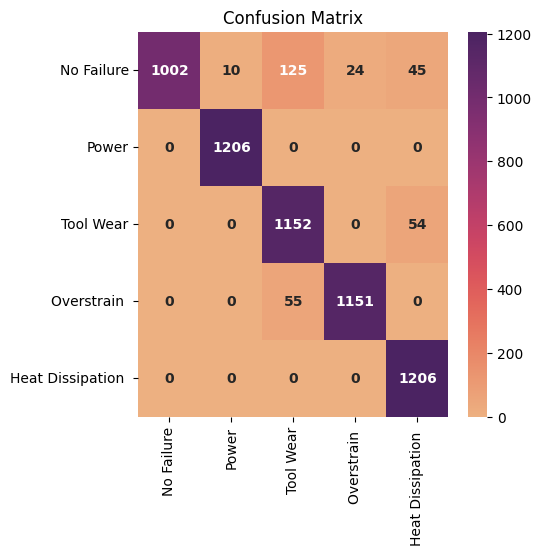

In [58]:
# получим метрики качества
accuracy_lr_mult, auc_lr_mult, f1_lr_mult, cm_lr_mult = fit_models_mult(model_lr_mult, features_train_up_mult,
                                                                                         features_test_up_mult, target_train_up_mult,
                                                                                         target_test_up_mult)

####  RandomForest

In [59]:
# обучим модель случайного леса на сбалансированной выборке
model_rf_mult = RandomForestClassifier(random_state=123, n_estimators=500, max_depth=10) # создадим модель

Значение accuracy = 0.8954, ROC-AUC = 0.994, f1 = 0.8981 



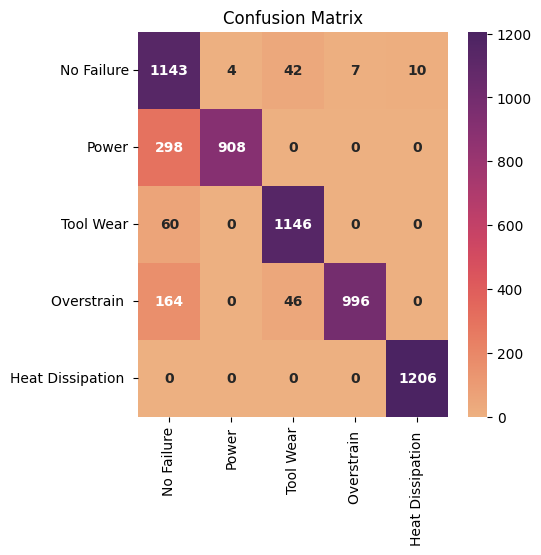

In [60]:
# получим метрики качества
accuracy_rf_mult, auc_rf_mult, f1_rf_mult, cm_rf_mult = fit_models_mult(model_rf_mult, features_train_up_mult,
                                                                                         features_test_up_mult, target_train_up_mult,
                                                                                         target_test_up_mult)

####  CatBoostClassifier

In [61]:
# обучим модель градиентного спуска на сбалансированной выборке
model_c_mult = CatBoostClassifier(verbose=False,learning_rate = 0.01 )

Значение accuracy = 0.8965, ROC-AUC = 0.9907, f1 = 0.8979 



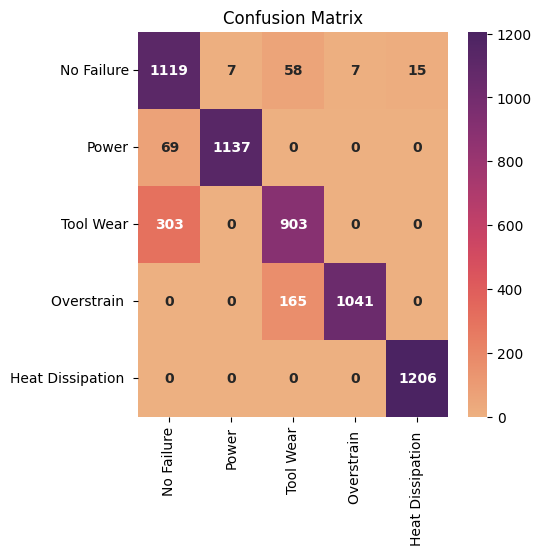

In [62]:
# получим метрики качества
accuracy_c_mult, auc_c_mult, f1_c_mult, cm_c_mult = fit_models_mult(model_c_mult, features_train_up_mult,
                                                                                         features_test_up_mult, target_train_up_mult,
                                                                                         target_test_up_mult)

####  XGBClassifier

In [63]:
# обучим модель  на сбалансированной выборке
model_x_mult = XGBClassifier(verbose=False, iterations=1000, learning_rate = 0.01)

Значение accuracy = 0.9391, ROC-AUC = 0.984, f1 = 0.9395 



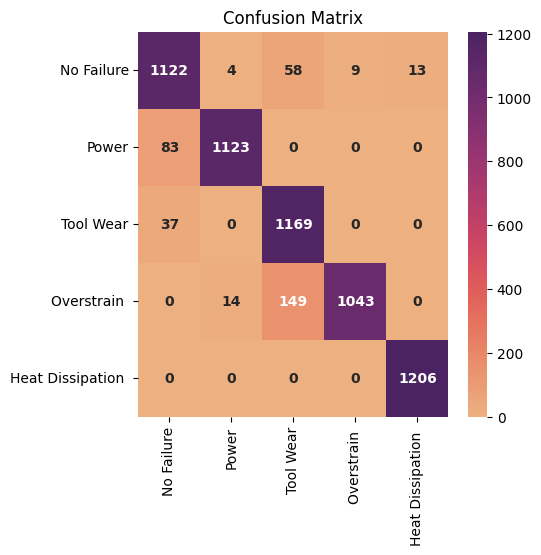

In [64]:
# получим метрики качества
accuracy_x_mult, auc_x_mult, f1_x_mult, cm_x_mult = fit_models_mult(model_x_mult, features_train_up_mult,
                                                                                         features_test_up_mult, target_train_up_mult,
                                                                                         target_test_up_mult)

In [65]:
# выбор лучшей модели
column=['Accuracy', 'ROC-AUC', 'F1']

summary = pd.DataFrame(index=column, columns=['LogisticRegression','RandomForest','CatBoostClassifier', 'XGBClassifier'])
summary['LogisticRegression'] = accuracy_lr_mult, auc_lr_mult, f1_lr_mult
summary['RandomForest'] = accuracy_rf_mult, auc_rf_mult, f1_rf_mult
summary['CatBoostClassifier'] = accuracy_c_mult, auc_c_mult, f1_c_mult
summary['XGBClassifier'] = accuracy_x_mult, auc_x_mult, f1_x_mult
summary.T

,Accuracy,ROC-AUC,F1
LogisticRegression,0.948093,0.987917,0.947735
RandomForest,0.895357,0.994030,0.898126
CatBoostClassifier,0.896517,0.990670,0.897885
XGBClassifier,0.939138,0.984037,0.939520


Итак, наилучшая модель многоклассовой классификации основана на алгоритме - LogisticRegression но и XGBClassifier показал неплохие результаты. Немного позже посмотрим как она покажет себя на тестовой выборке

In [66]:
# сохраним лучшую модель
filename = 'LogisticRegression_best_model.pkl'
joblib.dump(model_lr_mult, filename)

['LogisticRegression_best_model.pkl']

# Тестирование модели

## Целевой признак 'Target', задача бинарной классификации

In [67]:
from google.colab import files

files.download('CatBoost_best_model.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [68]:
#загрузка файла модели
CatBoost_loaded = joblib.load('CatBoost_best_model.pkl')

Значение accuracy = 0.9, precision = 0.9753, recall = 0.8207, f1 = 0.8914 



<Axes: >

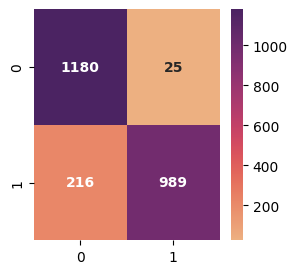

In [69]:
# Использование загруженной модели для предсказания
target_pred = CatBoost_loaded.predict(features_valid_up)
accuracy = accuracy_score(target_valid_up,target_pred)
precision = precision_score(target_valid_up,target_pred)
recall = recall_score(target_valid_up,target_pred)
f1 = f1_score(target_valid_up,target_pred)
cm = confusion_matrix(target_valid_up,target_pred)
print(f"Значение accuracy = {round(accuracy,4)}, precision = {round(precision,4)}, recall = {round(recall,4)}, f1 = {round(f1,4)} ")
print('')
plt.figure(figsize=(3,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='flare', annot_kws={"size": 10, "weight": "bold"})

Как видим, на тестовой выборке модель дает так же хорошие результаты

## Целевой признак 'Failure Type', задача многоклассовой классификации

In [70]:
files.download('LogisticRegression_best_model.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [71]:
#загрузка файла модели
LogisticRegression_loaded = joblib.load('LogisticRegression_best_model.pkl')

Значение accuracy = 0.9331, ROC-AUC = 0.976, f1 = 0.932 



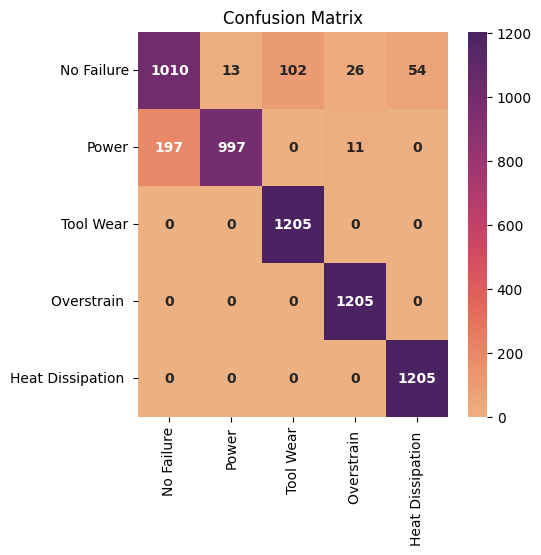

In [72]:
# Использование загруженной модели для предсказания
pred  = LogisticRegression_loaded.predict(features_valid_up_mult)
proba = LogisticRegression_loaded.predict_proba(features_valid_up_mult)
accuracy = accuracy_score(target_valid_up_mult,pred)
auc = roc_auc_score(target_valid_up_mult, proba, multi_class='ovr', average='weighted')
f1 = f1_score(target_valid_up_mult,pred, average='weighted')
cm = confusion_matrix(target_valid_up_mult,pred)
print(f"Значение accuracy = {round(accuracy,4)}, ROC-AUC = {round(auc,4)}, f1 = {round(f1,4)} ")
print('')
labels =  ['No Failure',
               'Power',
               'Tool Wear',
               'Overstrain ',
               'Heat Dissipation ']
fig, axes = plt.subplots(1, 1, figsize=[5,5])
plt.title('Confusion Matrix')
hmap = sns.heatmap(cm,
                   ax=axes,
                   annot=True,
                   fmt='d',
                   cmap='flare',
                   annot_kws={"size": 10, "weight": "bold"},
                   xticklabels=labels,
                   yticklabels=labels)
plt.show()

# Выводы

В ходе проделанной работы мы:

- изучили файл с данными, выявили отсутствие коррелирующих признаков, удалили несколько значений противоречящих друг другу
- обнаружили 2 целевых признака- выйдет ли машина из строя, и тип отказа
- разделили признаки на обучающие и целевую переменную
- разделили данные на три выборки: обучающую, валидационную и тестовую
- перекодировали категориальные признаки, маштабировали выборки
- выявили дисбаланс классов и сбалансировали выборку
- Обучили модели - 'LogisticRegression','RandomForest','CatBoostClassifier', 'XGBClassifier'
- сравнили метрики качества и выяснили что лучше всего для бинарной классификации показала себя модель CatBoostClassifier,  а для многоклассовой классификации лучшей оказалась модель LogisticRegression
- проверили модели на валидационной выборке, и убедились в качестве полученных предсказаний

В итоге можно сделать вывод, что для обеих задач выбранные модели работают  хорошо.

